In [4]:
import pyopenms
import matplotlib.pyplot as plt
from pyopenms.plotting import plot_spectrum
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
from io import BytesIO
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

In [6]:
file_path = '../../../DL/DATASET/wwtp3_hit_smiles_std.mgf'
half_150_test = '../../../DL/DATASET/half_150_test.mgf'
half_150_train = '../../../DL/DATASET/half_150_train.mgf'
exp = pyopenms.MSExperiment()
half_150_test_exp = pyopenms.MSExperiment()
half_150_train_exp = pyopenms.MSExperiment()
pyopenms.FileHandler().loadExperiment(file_path, exp)
pyopenms.FileHandler().loadExperiment(half_150_test, half_150_test_exp)
pyopenms.FileHandler().loadExperiment(half_150_train, half_150_train_exp)

Comparison of two spectra

In [7]:
def plot_two_spectra_advanced(
    spectrum1,
    spectrum2,
    label1="Spectrum 1",
    label2="Spectrum 2",
    title="Spectrum Comparison with Top 3 Peaks Labeled",
    smiles='',
    anomy='',
    name='',
    is_pfas=False,
):
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 7))  # 加大圖形尺寸
    
    peaks1 = spectrum1.get_peaks()
    peaks2 = spectrum2.get_peaks()
    
    # Normalize intensities
    # max_intensity = max(max(peaks1[1]), max(peaks2[1]))
    norm_peaks1 = peaks1[1] / max(peaks1[1])
    norm_peaks2 = peaks2[1] / max(peaks2[1])

    # Plot spectra
    stem1 = ax1.stem(peaks1[0], norm_peaks1, markerfmt=' ', basefmt=' ', linefmt='b-', label=label1)
    stem2 = ax1.stem(peaks2[0], norm_peaks2, markerfmt=' ', basefmt=' ', linefmt='r-', label=label2)
    
    # 找出每個spectrum強度前三高的peaks
    def get_top3_peaks(mz_array, intensity_array):
        peaks = list(zip(mz_array, intensity_array))
        return sorted(peaks, key=lambda x: x[1], reverse=True)[:4]
    
    top3_1 = get_top3_peaks(peaks1[0], norm_peaks1)
    top3_2 = get_top3_peaks(peaks2[0], norm_peaks2)
    
    # 改進的標註位置計算
    def get_annotation_positions(peaks, index, pos):
        """根據peak位置計算合適的標註位置"""
        positions = []
        for i, (mz, intensity) in enumerate(peaks):
            # 交替標註在左側和右側
            if (i + pos) % 2 == 0:
                xytext = (-60 if index == 0 else -80, 40 + i*5)
                ha = 'right'
            else:
                xytext = (60 if index == 0 else 80, 40 + i*5)
                ha = 'left'
            positions.append((xytext, ha))
        return positions
    
    # 獲取標註位置
    pos1 = get_annotation_positions(top3_1, 0, 1)
    pos2 = get_annotation_positions(top3_2, 1, 0)
    
    # 標註spectrum1的前三高peaks (藍色)
    for (mz, intensity), (xytext, ha) in zip(top3_1, pos1):
        ax1.annotate(f"{mz:.4f}", 
                    xy=(mz, intensity),
                    xytext=xytext,
                    textcoords='offset points',
                    color='blue',
                    ha=ha,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='blue', lw=1, alpha=0.8),
                    arrowprops=dict(arrowstyle="->", color='blue', connectionstyle="arc3,rad=-0.0"))
    
    # 標註spectrum2的前三高peaks (紅色)
    for (mz, intensity), (xytext, ha) in zip(top3_2, pos2):
        ax1.annotate(f"{mz:.4f}", 
                    xy=(mz, intensity),
                    xytext=xytext,
                    textcoords='offset points',
                    color='red',
                    ha=ha,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', lw=1, alpha=0.8),
                    arrowprops=dict(arrowstyle="->", color='red', connectionstyle="arc3,rad=-0.0"))
    
    # 圖形設置
    ax1.set_ylim(0, 1.3)  # 增加更多空間
    ax1.set_ylabel("Normalized Intensity")
    ax1.set_xlabel("m/z")
    ax1.set_title(title)
    ax1.legend(loc='upper right')

    # 添加網格線提高可讀性
    # ax1.grid(True, linestyle='--', alpha=0.6)

    # 生成分子結構圖
    def draw_molecule(smiles, size=(300,300)):
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        d2d = Draw.MolDraw2DCairo(size[0], size[1])
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        return Image.open(BytesIO(d2d.GetDrawingText()))
    
    # 選擇圖中空白區域放置分子結構 (右上角)
    x_pos = 0.22  # x軸位置 (0-1比例)
    y_pos = 0.8  # y軸位置 (0-1比例)
    
    # 繪製分子結構 (PFPrA: Perfluoropropionic acid)
    img = draw_molecule(smiles, size=(300, 300))
    
    # 將分子結構嵌入到譜圖中
    imagebox = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(imagebox, (x_pos, y_pos),
                       xycoords='axes fraction',
                       box_alignment=(0.5,0.5),
                       frameon=False)
    ax1.add_artist(ab)
    
    # 添加分子名稱標註
    ax1.text(x_pos, y_pos-0.2, f"{anomy}\n({name})",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12,
           bbox=dict(facecolor='white', alpha=0.0, edgecolor='gray', boxstyle='round,pad=0.2'))

    # 添加可能的碎片化註釋
    ax1.text(0.55, 0.5, "Annotated as PFAS by DeePFAS\n(the spectrum in WWTP3):",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12, fontdict={'color': 'black'},
           bbox=dict(facecolor='white', alpha=0, edgecolor='gray', boxstyle='round,pad=0.2'))

    ax1.text(0.55, 0.45, "YES" if is_pfas else "NO",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12, fontdict={'color': 'green' if is_pfas else 'red'},
           bbox=dict(facecolor='white', alpha=0, edgecolor='gray', boxstyle='round,pad=0.2'))
    plt.tight_layout()
    plt.show()


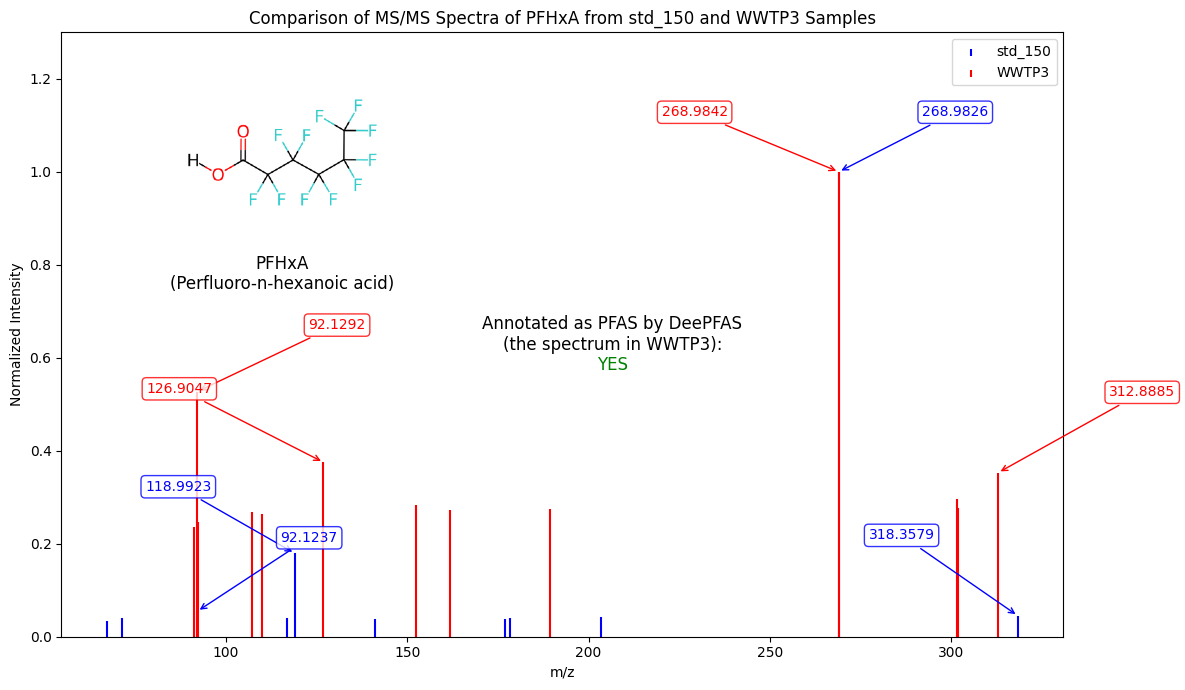

In [8]:

plot_two_spectra_advanced(
    half_150_train_exp[19],
    exp[125],
    "std_150",
    "WWTP3",
    "Comparison of MS/MS Spectra of PFHxA from std_150 and WWTP3 Samples", 
    "O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F",
    "PFHxA",
    "Perfluoro-n-hexanoic acid",
    True
    )


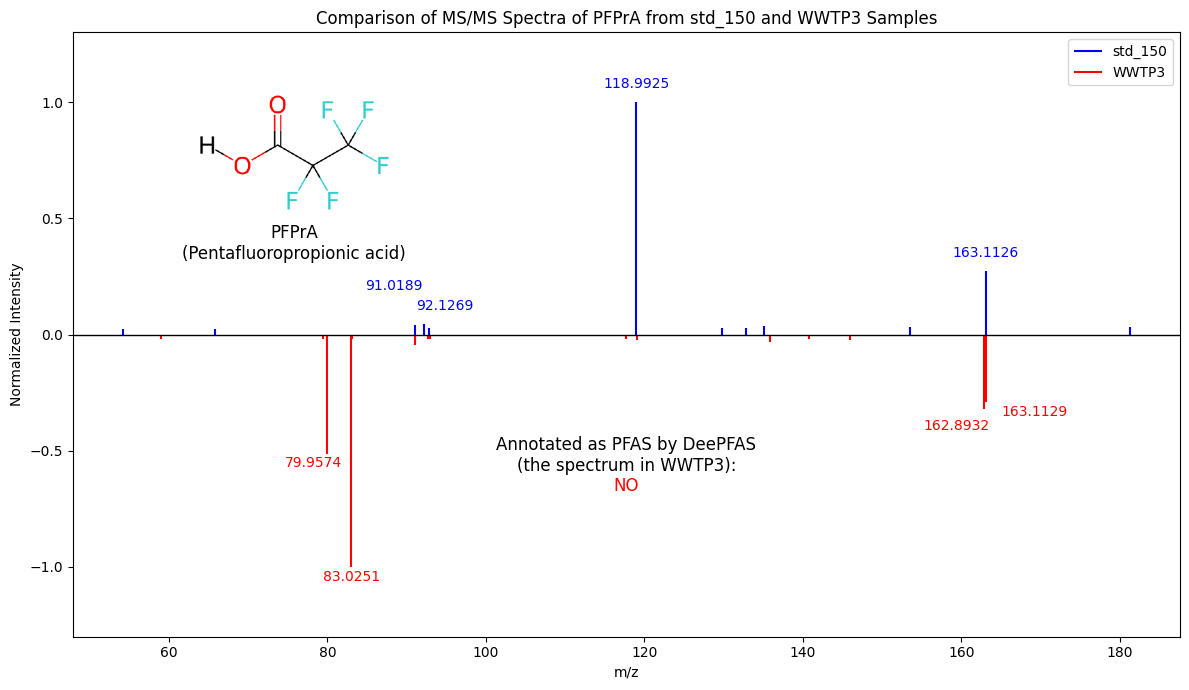

In [9]:
def plot_two_spectra_mirror(
    spectrum1,
    spectrum2,
    label1="Spectrum 1",
    label2="Spectrum 2",
    title="Mirror Spectrum Comparison",
    smiles='',
    anomy='',
    name='',
    is_pfas=False,
):
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 7))

    peaks1 = spectrum1.get_peaks()
    peaks2 = spectrum2.get_peaks()

    # Normalize intensities
    norm_peaks1 = peaks1[1] / max(peaks1[1])
    norm_peaks2 = peaks2[1] / max(peaks2[1])

    # Mirror: 第二個光譜強度取負值
    norm_peaks2 = -norm_peaks2

    # Plot mirror spectra
    ax1.vlines(peaks1[0], [0], norm_peaks1, color="blue", label=label1)
    ax1.vlines(peaks2[0], [0], norm_peaks2, color="red", label=label2)
    # stem1 = ax1.stem(peaks1[0], norm_peaks1, markerfmt=' ', basefmt=' ', linefmt='b-', label=label1)
    # stem2 = ax1.stem(peaks2[0], norm_peaks2, markerfmt=' ', basefmt=' ', linefmt='r-', label=label2)

    # 標註 Spectrum1 的前四高 peaks
    top4_1 = sorted(zip(peaks1[0], norm_peaks1), key=lambda x: x[1], reverse=True)[:4]
    x_axis_pos_std = [0, 0, 15, -15]
    y_axis_pos_std = [10, 10, 10, 25]
    x_axis_pos_wwtp3 = [0, -10, -20, 35]
    y_axis_pos_wwtp3 = [-10, -10, -15, -10]

    for idx, (mz, intensity) in enumerate(top4_1):
        ax1.annotate(f"{mz:.4f}", xy=(mz, intensity), xytext=(x_axis_pos_std[idx], y_axis_pos_std[idx]),
                     textcoords="offset points", color="blue", ha="center")

    # 標註 Spectrum2 的前四高 peaks
    top4_2 = sorted(zip(peaks2[0], norm_peaks2), key=lambda x: x[1], reverse=False)[:4]
    for idx, (mz, intensity) in enumerate(top4_2):
        ax1.annotate(f"{mz:.4f}", xy=(mz, intensity), xytext=(x_axis_pos_wwtp3[idx], y_axis_pos_wwtp3[idx]),
                     textcoords="offset points", color="red", ha="center")

    # # 改進的標註位置計算
    # def get_annotation_positions(peaks, index, pos):
    #     """根據peak位置計算合適的標註位置"""
    #     positions = []
    #     for i, (mz, intensity) in enumerate(peaks):
    #         # 交替標註在左側和右側
    #         if (i + pos) % 2 == 0:
    #             xytext = (-60 if index == 0 else -80, 40 + i*5)
    #             ha = 'right'
    #         else:
    #             xytext = (60 if index == 0 else 80, 40 + i*5)
    #             ha = 'left'
    #         positions.append((xytext, ha))
    #     return positions
    
    # # 獲取標註位置
    # pos1 = get_annotation_positions(top4_1, 0, 1)
    # pos2 = get_annotation_positions(top4_2, 1, 0)
    
    # # 標註spectrum1的前三高peaks (藍色)
    # for (mz, intensity), (xytext, ha) in zip(top4_1, pos1):
    #     ax1.annotate(f"{mz:.4f}", 
    #                 xy=(mz, intensity),
    #                 xytext=xytext,
    #                 textcoords='offset points',
    #                 color='blue',
    #                 ha=ha,
    #                 bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='blue', lw=1, alpha=0.8),
    #                 arrowprops=dict(arrowstyle="->", color='blue', connectionstyle="arc3,rad=-0.0"))
    
    # # 標註spectrum2的前三高peaks (紅色)
    # for (mz, intensity), (xytext, ha) in zip(top4_2, pos2):
    #     ax1.annotate(f"{mz:.4f}", 
    #                 xy=(mz, intensity),
    #                 xytext=xytext,
    #                 textcoords='offset points',
    #                 color='red',
    #                 ha=ha,
    #                 bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', lw=1, alpha=0.8),
    #                 arrowprops=dict(arrowstyle="->", color='red', connectionstyle="arc3,rad=-0.0"))
        
    # 生成分子結構圖
    def draw_molecule(smiles, size=(300,300)):
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        d2d = Draw.MolDraw2DCairo(size[0], size[1])
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        return Image.open(BytesIO(d2d.GetDrawingText()))
    
    # 選擇圖中空白區域放置分子結構 (右上角)
    x_pos = 0.2  # x軸位置 (0-1比例)
    y_pos = 0.8  # y軸位置 (0-1比例)
    
    # 繪製分子結構 (PFPrA: Perfluoropropionic acid)
    img = draw_molecule(smiles, size=(300, 300))
    
    # 將分子結構嵌入到譜圖中
    imagebox = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(imagebox, (x_pos, y_pos),
                       xycoords='axes fraction',
                       box_alignment=(0.5,0.5),
                       frameon=False)
    ax1.add_artist(ab)

    # 添加可能的碎片化註釋
    ax1.text(0.5, 0.3, "Annotated as PFAS by DeePFAS\n(the spectrum in WWTP3):",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12, fontdict={'color': 'black'},
           bbox=dict(facecolor='white', alpha=0, edgecolor='gray', boxstyle='round,pad=0.2'))

    ax1.text(0.5, 0.25, "YES" if is_pfas else "NO",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12, fontdict={'color': 'green' if is_pfas else 'red'},
           bbox=dict(facecolor='white', alpha=0, edgecolor='gray', boxstyle='round,pad=0.2'))

    # 添加分子名稱標註
    ax1.text(x_pos, y_pos-0.15, f"{anomy}\n({name})",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12,
           bbox=dict(facecolor='white', alpha=0.0, edgecolor='gray', boxstyle='round,pad=0.2'))
    # Set labels and title
    ax1.set_ylim(-1.3, 1.3)
    ax1.set_ylabel("Normalized Intensity")
    ax1.set_xlabel("m/z")
    ax1.set_title(title)
    ax1.axhline(0, color="black", linewidth=1)  # 中間的基準線
    ax1.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


# 使用範例
plot_two_spectra_mirror(
    half_150_test_exp[21],
    exp[13],
    "std_150",
    "WWTP3",
    "Comparison of MS/MS Spectra of PFPrA from std_150 and WWTP3 Samples",
    "O=C(O)C(F)(F)C(F)(F)F",
    "PFPrA",
    "Pentafluoropropionic acid",
    False
)